# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (1er entrega)

## Fecha de entrega

*26/09/2022*

## Integrantes

* <Tyler, Cruz>
* <Santiago, Franco>
* <Felipe, Merlo>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la funcion de ejemplo (`ruidoRosa_voss`).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) completado y con las celdas ejecutas a myommi@untref.edu.ar.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf 
import sounddevice as sd
from time import localtime, strftime

## Función de sintetización de ruido rosa
El ruido rosa o ruido $\frac{1}{\sqrt{f}}$ , dónde $f$ denota frecuencia en Hz, es un ruido con una distribución de frecuencias tal que su densidad espectral de potencia es proporcional a la inversa de la frecuencia. Esto implica que su nivel, por bandas de tercio de octava, es constante. El nivel del ruido rosa por intervalo fijo de frecuencias va decayendo a razón de 3 dB/octava, de forma no lineal aunque las frecuencias se representan en un eje lineal.

![Espectro del ruido rosa](../img/image44.png)
<center><b>Fig 1.</b> Espectro del ruido rosa.</center>

Se adjunta a continuación una función que devuelva un ruido rosa sintetizado a partir del algoritmo de Voss y Clarke (pueden encontrar mas informacion en [este enlace](https://www.dsprelated.com/showabstract/3933.php) y en [este notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)). 

**Consigna:** modificar la función original para que reciba como parametro la duración del ruido en segundos $t$ y como parametro opcional la frecuencia de muestreo $fs$ (Ayuda: la longitud de la señal sera el producto entre ambos). La función debe guardar el archivo de audio .wav de la señal generada y devolver el vector de datos de la señal.

In [41]:
def ruidoRosa_voss(t, ncols=16, fs=44100):
    """
    Genera ruido rosa utilizando el algoritmo de Voss-McCartney (https://www.dsprelated.com/showabstract/3933.php).
    
    .. Nota:: si 'ruido_rosa.wav' existe, este será sobreescrito.
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos, este determina la duración del ruido generado.
    ncols: int
        Determina el número de fuentes a aleatorias a agregar.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Generar un `.wav` desde un numpy array de 10 segundos con ruido rosa a una 
    frecuencia de muestreo de 44100 Hz.
    
        import numpy as np
        import pandas as pd
        import soundfile as sf
        
        ruidoRosa_voss(10)
    """
    
    nrows = int(float(t)*fs)

    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)

    # El número total de cambios es nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1)

    # Centrado del array en 0
    total = total - total.mean()

    # Normalizado
    valor_max = max(abs(max(total)), abs(min(total)))
    total = total / valor_max

    # Generación de archivo de audio .wav
    sf.write('ruido_rosa.wav', total, fs)

    return total

Ejemplo
    Generar un `.wav` desde un numpy array de 10 segundos con ruido rosa a una 
    frecuencia de muestreo de 44100 Hz.

In [42]:
ruido_rosa = ruidoRosa_voss(10)

Realizar una función para visualizar el dominio temporal de la señal.

In [43]:
def dominio_temporal(f,t,fs=44100):
    """
    Grafica el dominio temporal de una señal de un tiempo determinado.
    
    Parametros
    ----------
    f : array
        Numpy array de la señal a graficar.
    t : float
        Valor temporal en segundos.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: Gráfico de la señal.

    Ejemplo
    -------
    Generar un gráfico desde una señal de ruido rosa a una 
    frecuencia de muestreo de 44100 Hz.
    
        import numpy as np
        import matplotlib.pyplot as plt
        
        dominio_temporal(ruido_rosa,10)
    """
    
    # Eje x: tiempo
    x = np.linspace(0,t,t*fs)
    plt.xlabel('Tiempo (s)')
    
    # Eje y: amplitud normalizada
    y = f
    plt.ylabel('Amplitud')
    
    plt.title('Dominio temporal de la señal')
    plt.plot(x, y)
    
    return plt.show()

Llamar a la función.

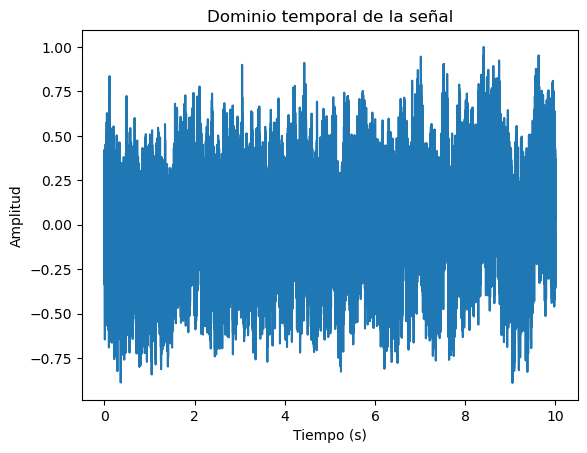

In [44]:
dominio_temporal(ruido_rosa,10)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

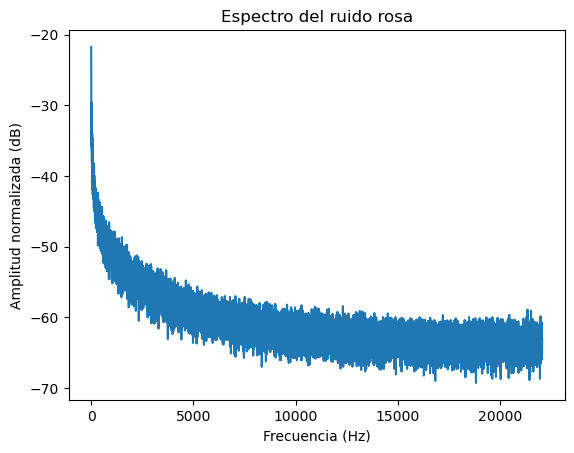

In [45]:
pn_spectrum = pd.read_csv('./pinknoise_spectrum.txt',delimiter='\t') # Lee el archivo de texto generado en Audacity

# Eje x: frecuencia
x = pn_spectrum['Frequency (Hz)'] # Accede a la columna de frecuencias
plt.xlabel('Frecuencia (Hz)')
    
# Eje y: nivel (dB)
y = pn_spectrum['Level (dB)'] # Accede a la columna de amplitud
plt.ylabel('Amplitud normalizada (dB)')
    
plt.title('Espectro del ruido rosa')
plt.plot(x, y)
plt.show()

Reproducir resultado.

In [46]:
sd.play(ruido_rosa)
sd.wait()

## Funcion de generación de sine sweep logaritmico + filtro inverso
El sine sweep es el método más indicado para generar el impulso por medio de la convolución (Nikolić, I., and O. H. Bjor, 2003). Dado que métodos tales como: explosión de globo, aplauso, disparo con pistola se salva, paper gun ([Paper Popper](https://en.wikipedia.org/wiki/Paper_popper)), golpe entre maderas, petardos, entre otros, carecen de reproducibilidad. Esto es debido a su nivel sonoro, duración y características espectrales, además de una muy baja relación señal ruido, la cual difícilmente se solucione filtrando o promediando con muchas mediciones. Comencemos por ver cómo generar el sine sweep logarítmico $x(t)$ que posee la siguiente forma:

\begin{equation}
f(x) = \sin[\theta(t)]= \sin[K (e^\frac{t}{L} - 1) ]
\tag{1}
\end{equation}

Donde:

\begin{equation}
K = \frac{T w_{1}}{R}
\end{equation}

\begin{equation}
L = \frac{T}{R}
\end{equation}

y el sweep rate $R$: 

\begin{equation}
R = \ln \left( \frac{w_{2}}{w_{1}} \right)
\tag{2}
\end{equation}

Con $w_{1}$ y $w_{2}$, las frecuencias angulares inferior y superior respectivamente, $T$ es el tiempo de duración del sine sweep en segundos (Meng, Q., 2008). Si estudiamos el espectro de la señal de la ecuación (1), se observa que no es plano, sino que disminuye a razón de -3 dB/octava, como el ruido rosa (Ver fig. 2, sup). De modo que el espectro de $x(-t)$ debe ser ajustado, aumentando en 3 dB/octava, de modo que cuando realizamos el cálculo se restaure la plenitud perfecta de la respuesta de impulso medida $h(t)$ (Farina A., 2000) (Ver fig. 2, inf).

![](../img/image43.png)
<center><b>Fig 2.</b> Espectro del sine sweep. Sine sweep logarítmico  (sup). Filtro invertido (inf).</center>


En el dominio temporal las señales del sine sweep logarítmico y el filtro inverso se comportan de la siguiente manera (Ver fig. 3). 

![](../img/image46.png)
<center><b>Fig 3.</b> Magnitud del sine sweep. Sine sweep logarítmico (sup). Filtro invertido (inf).</center>

Para generar el filtro inverso $k(t)$ del sine sweep logarítmico $x(t)$ se requiere de una modulación $m(t)$ definida por la siguiente expresión:

\begin{equation}
m(t) = \frac{w_{1}}{2\pi w(t)}
\tag{3}
\end{equation}

Obtenida de la frecuencia instantánea (dado que la amplitud cambia en función de la
frecuencia), calculada a partir de la ecuación (1):

\begin{equation}
w(t)=\frac{d[\theta (t)]}{dt}=\frac{K}{L} e^\frac{t}{L}
\tag{4}
\end{equation}
m
entonces, el filtro inverso $k(t)$ queda definido como:

\begin{equation}
k(t)=m(t)x(-t)
\tag{5}
\end{equation}

**Consigna:** realizar una función generadora de un sine sweep y su filtro inverso, a partir de las ecuaciones descriptas anteriormente, y graficar el resultado de ambos filtros, usando la función anteriormente creada. Recordar almacenar los audios. Agregar docstring que indique claramente los parametros de entrada y salida.

In [47]:
def sine_sweep(t,f1,f2,fs=44100):
    """
    Genera un Sine Sweep y su filtro inverso utilizando las ecuaciones de Meng, Q.
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos, este determina la duración del ruido generado.
    f1: int
        Frencuancia inferior en Hz.
    f2: int
        Frencuancia superior en Hz.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de las señales generadas.
    
    Ejemplo
    -------
    Generar dos `.wav` desde un numpy array de 10 segundos con sine sweep y su filtro inverso a una 
    frecuencia de muestreo de 44100 Hz.
    
        import numpy as np
        import soundfile as sf
        
        sine_sweep(10,20,20000)
    """

    # Frecuencia angular
    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2
    
    # Definición del sine sweep 
    T = np.linspace(0,t,t*fs)
    R = np.log(w2/w1)
    L = t/R
    K = (t*w1)/R

    sine_sweep_t = np.sin(K*(np.exp(T/L)-1))

    # Frecuencia instantánea
    w = (K/L)*np.exp(T/L)

    # Modulación
    m = w1/2*np.pi*w 
    
    # Definición del filtro inverso
    filtro_inverso = m * np.sin(K*(np.exp(-T/L)-1))

    # Generación de archivos de audio .wav
    sf.write('sine_sweep.wav', sine_sweep_t, fs)
    sf.write('filtro_inverso.wav',filtro_inverso, fs)

    return sine_sweep_t, filtro_inverso

Llamar la función.

In [48]:
sine_sweep = sine_sweep(10,20,20000)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

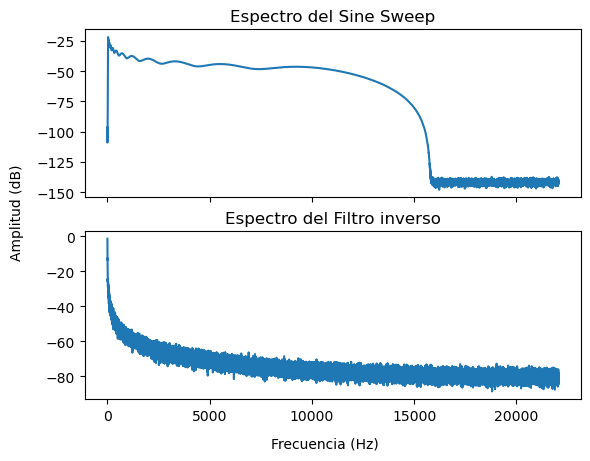

In [49]:
ss_spectrum = pd.read_csv('./sine_sweep_spectrum.txt',delimiter='\t') # Lee el archivo de texto generado en Audacity

# Eje x: frecuencia
x1 = ss_spectrum['Frequency (Hz)'] # Accede a la columna de frecuencias
# Eje y: nivel (dB)
y1 = ss_spectrum['Level (dB)'] # Accede a la columna de amplitud

fi_spectrum = pd.read_csv('./filtro_inverso_spectrum.txt',delimiter='\t') # Lee el archivo de texto generado en Audacity

# Eje x: frecuencia
x2 = fi_spectrum['Frequency (Hz)'] # Accede a la columna de frecuencias
# Eje y: nivel (dB)
y2 = fi_spectrum['Level (dB)'] # Accede a la columna de amplitud

fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(x1,y1) # Gráfico del Sine Sweep
ax1.set_title('Espectro del Sine Sweep')
ax2.plot(x2,y2) # Gráfico del Filtro Inverso
ax2.set_title('Espectro del Filtro inverso')
fig.text(0.5,0.008,'Frecuencia (Hz)', ha='center')
fig.text(0.008,0.5,'Amplitud (dB)', va='center', rotation='vertical')
plt.show()

Reproducir resultados.

In [50]:
# Reproducir sine sweep
ss = sine_sweep[0]
sd.play(ss)
sd.wait()

# Reproducir filtro inverso
fi = sine_sweep[1]
sd.play(fi)
sd.wait()

Prueba de convolución (sine sweep y filtro inverso)

In [51]:
# Convolución sine sweep y filtro inverso
convol = np.convolve(ss,fi)

# Generación de .wav
sf.write('convol.wav',convol,44100)

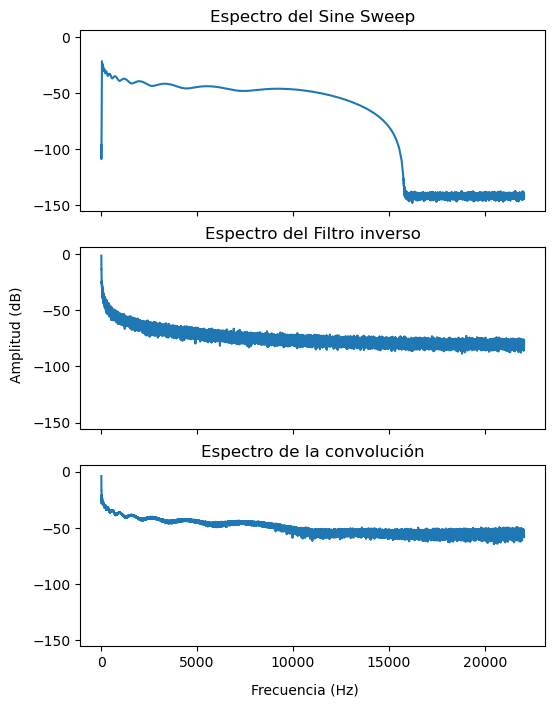

In [52]:
convol_spectrum = pd.read_csv('./convol_spectrum.txt',delimiter='\t') # Lee el archivo de texto generado en Audacity

# Eje x: frecuencia
x3 = convol_spectrum['Frequency (Hz)'] # Accede a la columna de frecuencias
# Eje y: nivel (dB)
y3 = convol_spectrum['Level (dB)'] # Accede a la columna de amplitud

fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True, sharey=True,figsize=(6,8))
ax1.plot(x1,y1) # Gráfico espectral del Sine Sweep
ax1.set_title('Espectro del Sine Sweep')
ax2.plot(x2,y2) # Gráfico espectral del Filtro Inverso
ax2.set_title('Espectro del Filtro inverso')
ax3.plot(x3,y3) # Gŕafico espectral de la convolución
ax3.set_title('Espectro de la convolución')
fig.text(0.5,0.05,'Frecuencia (Hz)', ha='center')
fig.text(0.008,0.5,'Amplitud (dB)', va='center', rotation='vertical')
plt.show()

## Función adquisicion y reproducción
**Consigna**: la función tiene que permitir la reproducción y la adquisición de manera simultánea para un tiempo determinado por el usuario. Es importante evaluar y constatar dicha simultaneidad. El módulo debería permitir seleccionar el hardware a utilizar. Algunos articulos de interes para el desarrollo:
* [Clase de audio](../../clases/clase_6/600_audio.ipynb)
* [Sound Device - Simultaneous Playback and Recording](https://python-sounddevice.readthedocs.io/en/0.4.1/usage.html#simultaneous-playback-and-recording)
* [Playing and Recording Sound in Python](https://realpython.com/playing-and-recording-sound-python/)
* [Audio in Python](https://wiki.python.org/moin/Audio/)
* [https://github.com/spatialaudio/python-sounddevice/issues/148](https://github.com/spatialaudio/python-sounddevice/issues/148)

In [53]:
def play_rec(filename, duration=None, end_delay=None, play_device_id=None, rec_device_id=None):
    """
    Reproduce un audio seleccionado y graba simultáneamente, según los dispositivos de audio elegidos. La grabación será guaradada en un archivo con el nombre 'recording' seguido de la fecha y hora local.

    Parametros
    ----------
    filename : str
        Nombre del archivo de audio a reproducir.
    duration(opcional): int
        Duración de la reproducción y adquisición, en segundos. Si no se elige una duración, la duración por defecto de la grabación y reproducción será igual a la duración del audio a reproducir.
    end_delay(opcional): int
        Delay en segundos, entre que se detiene la reproducción del audio y se termina la grabación. Si no se elige un tiempo de delay, la grabación terminará al mismo tiempo que se termine de reproducir el audio.
    play_device_id(opcional): int
        Número de ID del dispositivo de audio elegido para reproducir. Si no se indica en el argumento de la función, será solicitado al momento de correr la misma.
    rec_device_id(opcional): int
        Número de ID del dispositivo de audio elegido para grabar. Si no se indica en el argumento de la función, será solicitado al momento de correr la misma.

    .. Nota:: Si la duración elegida es mayor que el tiempo del audio a reproducir, el audio terminará de reproducirse y la función seguirá grabando hasta el tiempo indicado. Si la duración elegida es menor a la duración del audio a reproducir, la reproducción y la grabación se detendrán en el tiempo indicado.

    returns: NumPy array
        Datos del audio grabado.
    """

    # Ingresar nombre del archivo de audio a reproducir
    if filename == False:
        filename = input('Ingrese el nombre del archivo de audio .wav a reproducir: ') + '.wav'

    # Extraer datos del archivo de audio
    playdata, fs = sf.read(filename, dtype='float32')
    print('Playdata type = ' + str(type(playdata)))
    play_samples = int(len(playdata))  # Cantidad de muestras del archivo de audio cargado
    print('Play samples = ' + str(play_samples))
    play_time = play_samples/fs  # Duración original del archivo de audio cargado

    # Definir duración de la función
    duration_samples = int(duration * fs)  # Cantidad de muestras necesarias para la duración requerida
    print('Duration samples = ' + str(duration_samples))
    print('Duration samples type = ' + str(type(duration_samples)))
    end_delay_samples = int(end_delay * fs)  # Cantidad de muestras necesarias para el delay requerido
    print('End_delay samples = ' + str(end_delay_samples))
    end_delay_array = np.zeros(end_delay_samples)
    print('End delay array = ' + str(type(end_delay_array)))
    if duration < play_time and end_delay == None:
        playdata = playdata[:duration_samples]
    elif duration < play_time and end_delay != None:
        playdata = np.concatenate([playdata[:duration_samples], end_delay_array])
    elif duration > play_time and end_delay == None:
        playdata = np.concatenate([playdata, np.zeros(duration_samples - play_samples)])
    elif duration > play_time and end_delay != None:
        playdata = np.concatenate([playdata, np.zeros(duration_samples - play_samples), end_delay_array])

    # Elegir dispositivo de reproducción y grabación
    if play_device_id or rec_device_id == None:
        print('Listado de dispositivos de audio disponibles:\n')
        print(sd.query_devices())

    if play_device_id == None:
        play_device_id = int(
            input('Ingrese el número de la lista del dispositivo que desea utilizar para reproducir: '))

    if rec_device_id == None:
        rec_device_id = int(input('Ingrese el número de la lista del dispositivo que desea utilizar para grabar: '))

    # Establcer valores por defecto de la función
    sd.default.samplerate = fs
    sd.default.device = rec_device_id, play_device_id
    sd.default.channels = 2
    if duration == None:
        duration = playdata/fs

    # Reproducción y adquisición
    recording = sd.playrec(playdata)
    sd.wait()
    fecha_hora = strftime('%Y-%m-%d   %Hh-%Mm-%Ss', localtime())
    sf.write('recording ' + fecha_hora + '.wav', recording, fs)

    return recording, duration, end_delay

Llamar la función.

In [54]:
play_rec('ruido_rosa.wav',10,2,0,31)

Playdata type = <class 'numpy.ndarray'>
Play samples = 441000
Duration samples = 441000
Duration samples type = <class 'int'>
End_delay samples = 88200
End delay array = <class 'numpy.ndarray'>


(array([[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.10186768, 0.10186768],
        [0.14276123, 0.14276123],
        [0.0078125 , 0.0078125 ]], dtype=float32),
 10,
 2)

¿Cómo se podría medir la latencia de la función?

In [55]:
# Completar